In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt


# # NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Here's the column description:

'Username' = The Username

'PostID' = an ID string like 'kl6440' that corresponds directly to the individual post regardless of whether it is a submission or comment.

'Type' = 'Submission' or 'Comment'

'Title' = If the post was a submission to a subreddit it has a 'title'. Comments do not have a title field. All rows with 'type'= comment will have a null value in the 'Title' field.

'Content' = the body text of that row's Submission or Comment

'ContentTimestamp' = timestamp of that row's Submission or Comment

'RelatedSubmissionID' = an ID string that connects to the submission that the relevant post is connected to. For submissions this is the same as the PostID (because it is connected to itself) but for comments this provides the submission that started the thread that the comment is contained within. This is different from the parentID (see below) because RelatedSubmissionID points to the top of a comment tree, while the parentID points to whatever the comment was actually replying to.

'ParentID' = an ID string that points to the comment or submission that a comment was actually replying to. Only comments will have ParentIDs. Submissions cannot have ParentIDs.

IsSubmitter = TRUE/FALSE. Indicates if the user is commenting on their own submission chain. All 'submissions' will be FALSE. If this row is TRUE it means that the comment is in a thread that the user started.

'ContentSubreddit' = the name of the subreddit that the Submission or Comment was posted in.

'Upvotes' = number of upvotes that Submission or Comment recieved across it's livespan. Note that we do not have information about WHEN the upvotes were recieved. # Also, this can be a negative number. It includes a sum of upvotes and downvotes.

'SurveyCommentID' = an ID string that points to the survey response.

'SurveyResponse' = actual response from users to the survey Qs.

'SurveyTimestamp' = timestamp of the survey response.

'QuestionID' = 1 or 2. The survey question that the user responded to. 1 = Short-term happiness metric (Subjective Wellbeing). 2 = long-term happiness metric (Life Satisfaction).

'Score' = the value 1-10 that the user provided to the survey Q1 or Q2.


##Step 1 data Cleaning
This code loads the Reddit dataset and preprocesses the text in the 'Content' field by performing several steps: it removes URLs, special characters, and numbers; converts the text to lowercase; tokenizes it into words; removes English stopwords; and lemmatizes the words to their base forms. The cleaned text is then stored in a new column called 'CleanContent'. Additionally, any missing values in the 'Title' column are filled with empty strings to prevent issues during analysis. This preprocessing prepares the data for further analysis by standardizing the text content.

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = 'RedditSampleLlmScores.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply cleaning to the 'Content' field
df['CleanContent'] = df['Content'].apply(lambda x: clean_text(str(x)))

# Handle missing 'Title' values by filling with empty strings
df['Title'] = df['Title'].fillna('')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Step 2 Training the Word2Vec model
In this step, we train a Word2Vec model on the preprocessed Reddit text data to generate word embeddings that capture semantic relationships between words.

We first tokenize the cleaned text from the 'CleanContent' column using Gensim's simple_preprocess, resulting in a list of tokenized sentences. We initialize the Word2Vec model with a vector size of 300, a context window of 10 words, a minimum word frequency (min_count) of 5, and specify the use of the skip-gram architecture (sg=1) for training. After building the vocabulary from the tokenized sentences, we train the model over 15 epochs and save it for future use.

In [3]:
from gensim.models import Word2Vec

# Prepare sentences for Word2Vec
sentences = df['CleanContent'].apply(lambda x: x.split()).tolist()

# Train a Word2Vec model
word2vec_model = Word2Vec(
    sentences,
    vector_size=300,      # Dimension of embeddings
    window=10,            # Context window size
    min_count=5,          # Minimum word frequency to be included in the vocabulary
    workers=4,            # Number of worker threads
    sg=1                  # Skip-gram model; sg=0 for CBOW
)

# Save the model for future use
word2vec_model.save("word2vec_model.model")

# Example: Access word embedding for "example"
example_embedding = word2vec_model.wv['example']
print(f"Word embedding for 'example': {example_embedding}")


Word embedding for 'example': [-0.12375335  0.16772762  0.05835112  0.25822794  0.12047759 -0.08995785
  0.05505551  0.19967149  0.10555297  0.00328893  0.02776231 -0.06174686
  0.15541537  0.02283069 -0.2872273   0.09483188  0.12215202 -0.00866644
  0.16113262  0.01328971 -0.05948036  0.25396335  0.08008495 -0.16638754
  0.18199003  0.00733479 -0.11149433  0.02287179 -0.04473005 -0.14329071
  0.05306367 -0.0449043   0.07291306 -0.02409114 -0.14682189  0.27196378
  0.05241826  0.00148073 -0.1102357  -0.03171746 -0.19615282  0.04883391
 -0.13775359 -0.03318444 -0.0482784   0.17401804 -0.01331836  0.10681407
  0.0223946   0.15831798  0.1052557   0.03367321 -0.03243929  0.10789824
 -0.15303566  0.2800298   0.06996726 -0.02969557 -0.18733856  0.02674306
  0.10375791 -0.17728652 -0.05979355 -0.14445525 -0.16561955 -0.07091621
 -0.0409572   0.0730359   0.11543944 -0.06390728  0.02313435  0.01720437
  0.05997506 -0.10115967  0.2988323   0.1113345  -0.22521138  0.18003781
 -0.15191385 -0.04195

##Step 3 Load the XANEW dataset
In this step, we load the XANEW dataset (Warriner, A.B., Kuperman, V., & Brysbaert, M. (2013). Norms of valence, arousal, and dominance for 13,915 English lemmas. Behavior Research Methods, 45, 1191-1207.), to select seed words for our sentiment propagation model.

We ensure consistency by converting all words to lowercase. We calculate the 90th and 10th percentile thresholds for both valence (emotional positivity) and arousal (emotional intensity) scores. Using these thresholds, we select words that are both high in valence and high in arousal as positive seed words, and words that are low in valence but high in arousal as negative seed words.

We then print the number of seed words in each category to verify our selections.

Possible future updates might include experimenting with different percentile thresholds or considering additional combinations of valence and arousal levels for seed word selection.

In [4]:
import pandas as pd

# Load the XANEW dataset
xanew_df = pd.read_csv('xanew.csv', sep=',', index_col=0, keep_default_na=False)
print(xanew_df.head())

# Ensure all words are in lowercase for consistency
xanew_df['Word'] = xanew_df['Word'].str.lower()

# Step 1: Calculate percentile thresholds for each dimension
valence_high_percentile = xanew_df['V.Mean.Sum'].quantile(0.90)
valence_low_percentile = xanew_df['V.Mean.Sum'].quantile(0.10)
arousal_high_percentile = xanew_df['A.Mean.Sum'].quantile(0.90)
arousal_low_percentile = xanew_df['A.Mean.Sum'].quantile(0.10)
dominance_high_percentile = xanew_df['D.Mean.Sum'].quantile(0.90)
dominance_low_percentile = xanew_df['D.Mean.Sum'].quantile(0.10)

# Step 2: Define high and low seed words for each dimension
# Valence
high_valence_seeds = xanew_df[xanew_df['V.Mean.Sum'] >= valence_high_percentile]['Word'].tolist()
low_valence_seeds = xanew_df[xanew_df['V.Mean.Sum'] <= valence_low_percentile]['Word'].tolist()

# Arousal
high_arousal_seeds = xanew_df[xanew_df['A.Mean.Sum'] >= arousal_high_percentile]['Word'].tolist()
low_arousal_seeds = xanew_df[xanew_df['A.Mean.Sum'] <= arousal_low_percentile]['Word'].tolist()

# Dominance
high_dominance_seeds = xanew_df[xanew_df['D.Mean.Sum'] >= dominance_high_percentile]['Word'].tolist()
low_dominance_seeds = xanew_df[xanew_df['D.Mean.Sum'] <= dominance_low_percentile]['Word'].tolist()

# Step 3: Print the number of seeds for each category
print(f"Number of high valence seed words: {len(high_valence_seeds)}")
print(f"Number of low valence seed words: {len(low_valence_seeds)}")
print(f"Number of high arousal seed words: {len(high_arousal_seeds)}")
print(f"Number of low arousal seed words: {len(low_arousal_seeds)}")
print(f"Number of high dominance seed words: {len(high_dominance_seeds)}")
print(f"Number of low dominance seed words: {len(low_dominance_seeds)}")

# Step 4: Combine seed words into dictionaries for easy reference
seed_words = {
    'Valence': (high_valence_seeds, low_valence_seeds),
    'Arousal': (high_arousal_seeds, low_arousal_seeds),
    'Dominance': (high_dominance_seeds, low_dominance_seeds)
}

# Example: Inspect a subset of the seed words
print("\nSample High Valence Seeds:", high_valence_seeds[:10])
print("Sample Low Valence Seeds:", low_valence_seeds[:10])
print("Sample High Arousal Seeds:", high_arousal_seeds[:10])
print("Sample Low Arousal Seeds:", low_arousal_seeds[:10])
print("Sample High Dominance Seeds:", high_dominance_seeds[:10])
print("Sample Low Dominance Seeds:", low_dominance_seeds[:10])


          Word  V.Mean.Sum  V.SD.Sum  V.Rat.Sum  A.Mean.Sum  A.SD.Sum  \
1     aardvark        6.26      2.21         19        2.41      1.40   
2      abalone        5.30      1.59         20        2.65      1.90   
3      abandon        2.84      1.54         19        3.73      2.43   
4  abandonment        2.63      1.74         19        4.95      2.64   
5        abbey        5.85      1.69         20        2.20      1.70   

   A.Rat.Sum  D.Mean.Sum  D.SD.Sum  D.Rat.Sum  ...  A.Rat.L  A.Mean.H  A.SD.H  \
1         22        4.27      1.75         15  ...       11      2.55    1.29   
2         20        4.95      1.79         22  ...       12      2.38    1.92   
3         22        3.32      2.50         22  ...       11      3.82    2.14   
4         21        2.64      1.81         28  ...       14      5.29    2.63   
5         20        5.00      2.02         25  ...        9      2.55    1.92   

   A.Rat.H  D.Mean.L  D.SD.L  D.Rat.L  D.Mean.H  D.SD.H  D.Rat.H  
1      

<ipython-input-4-dfef90065183>:4: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  xanew_df = pd.read_csv('xanew.csv', sep=',', index_col=0, keep_default_na=False)


##Step 4: Sentiment Propagation Using SentProp

In this step, we implement the SentProp algorithm to propagate sentiment scores across the vocabulary based on seed words. (
Hamilton, W. L., K. Clark, J. Leskovec, and D. Jurafsky (2016): “Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora,” in Proceedings of the Conference on Empirical Meth- ods in Natural Language Processing. Conference on Empirical Methods in Natural Language Pro- cessing, vol. 2016, p. 595. NIH Public Access.)

The process is broken down into the following sub-steps:

###1. Extract Vocabulary and Word Vectors
We begin by extracting the vocabulary and word vectors from the trained Word2Vec model.

In [5]:
import numpy as np

# Extract vocabulary and word vectors from the trained Word2Vec model
vocab = list(word2vec_model.wv.index_to_key)
word_vectors = np.array([word2vec_model.wv[word] for word in vocab])

print(f"Vocabulary size: {len(vocab)}")
print(f"Word vector shape: {word_vectors.shape}")

Vocabulary size: 16110
Word vector shape: (16110, 300)


###2. Construct the k-Nearest Neighbors Graph
Create a graph where each word is connected to its k nearest neighbors based on cosine similarity.

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import networkx as nx

def build_knn_graph(word_vectors, k=10):
    # Compute cosine similarity
    similarities = cosine_similarity(word_vectors)
    np.fill_diagonal(similarities, 0)  # Remove self-similarities

    # For each word, retain connections to the k-nearest neighbors
    knn_graph = np.zeros_like(similarities)
    for i in range(similarities.shape[0]):
        knn_indices = similarities[i].argsort()[-k:]  # Indices of k largest similarities
        knn_graph[i, knn_indices] = similarities[i, knn_indices]

    # Convert to a sparse matrix
    knn_graph_sparse = csr_matrix(knn_graph)
    return knn_graph_sparse

# Build the kNN graph
knn_graph = build_knn_graph(word_vectors, k=10)

###3. Build the Graph Using NetworkX
Convert the k-NN graph into a NetworkX graph for easy manipulation.

In [7]:
def build_networkx_graph(knn_graph, vocab):
    """
    Build a NetworkX graph from a sparse adjacency matrix and map indices to words.
    """
    # Create a NetworkX graph from the sparse adjacency matrix
    G = nx.from_scipy_sparse_array(knn_graph)  # Updated method for newer versions of NetworkX

    # Map node indices to words
    mapping = {i: word for i, word in enumerate(vocab)}
    G = nx.relabel_nodes(G, mapping)

    return G

# Build the graph
G = build_networkx_graph(knn_graph, vocab)

# Check graph details
print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")

Number of nodes in the graph: 16110
Number of edges in the graph: 146297


###4. Compute the Transition Matrix
The transition matrix
T
T is derived from the adjacency matrix of the graph and normalized row-wise.

In [8]:
def compute_transition_matrix(G):
    # Get adjacency matrix
    adjacency_matrix = nx.to_numpy_array(G)

    # Normalize rows to create a transition matrix
    row_sums = adjacency_matrix.sum(axis=1)
    transition_matrix = adjacency_matrix / row_sums[:, np.newaxis]

    return transition_matrix

# Compute the transition matrix
T = compute_transition_matrix(G)
print(f"Transition matrix shape: {T.shape}")


Transition matrix shape: (16110, 16110)


###5. Initialize Seed Vectors
Prepare the seed vectors for Valence, Arousal, and Dominance dimensions.



In [9]:
def initialize_seed_vector(vocab, high_seeds, low_seeds):
    seed_vector = np.zeros(len(vocab))
    for i, word in enumerate(vocab):
        if word in high_seeds:
            seed_vector[i] = 1  # Positive sentiment
        elif word in low_seeds:
            seed_vector[i] = -1  # Negative sentiment
    return seed_vector

# Create seed vectors for each dimension
seed_vectors = {}
for dimension, (high_seeds, low_seeds) in seed_words.items():
    seed_vectors[dimension] = initialize_seed_vector(vocab, high_seeds, low_seeds)

print("Seed vectors initialized for Valence, Arousal, and Dominance.")


Seed vectors initialized for Valence, Arousal, and Dominance.


###6. Define the Propagation Function and Run Propagation
Implement the random walk propagation algorithm for each dimension.

In [10]:
def propagate_sentiment(T, seed_vector, max_iter=100, alpha=0.85):
    # Initialize the score vector
    scores = seed_vector.copy()
    for _ in range(max_iter):
        # Perform the random walk update
        scores = alpha * np.dot(T, scores) + (1 - alpha) * seed_vector

    return scores

# Run propagation for each dimension
propagated_scores = {}
for dimension, seed_vector in seed_vectors.items():
    print(f"Propagating scores for {dimension}...")
    propagated_scores[dimension] = propagate_sentiment(T, seed_vector)


Propagating scores for Valence...
Propagating scores for Arousal...
Propagating scores for Dominance...


###7. Create Sentiment Dictionaries
Map propagated scores back to words to create sentiment dictionaries for each dimension.

In [11]:
def create_sentiment_dictionary(vocab, scores):
    return {word: score for word, score in zip(vocab, scores)}

# Create dictionaries for each dimension
sentiment_dictionaries = {}
for dimension, scores in propagated_scores.items():
    sentiment_dictionaries[dimension] = create_sentiment_dictionary(vocab, scores)

# Display a sample of the Valence dictionary
print("Sample Valence Dictionary:")
print({k: v for k, v in list(sentiment_dictionaries['Valence'].items())[:10]})



Sample Valence Dictionary:
{'like': 0.1454375089513627, 'im': -0.010182702799427906, 'dont': -0.013315366213543428, 'get': -0.020278549583639612, 'one': 0.00772377920250322, 'people': -0.0125128711448288, 'would': -0.017282488213388875, 'time': -0.008350522250872088, 'know': 0.1521560332171877, 'think': 0.15768545297809994}


###8. Validation and Next Steps
Validation:
Compare the scores in each dictionary against human-labeled data (if available).
Use metrics like correlation with external sentiment tools (e.g., TextBlob, VADER).
Saving the Dictionaries:
Save the dictionaries to files for future use:

In [12]:
import json

for dimension, dictionary in sentiment_dictionaries.items():
    with open(f"{dimension}_dictionary.json", "w") as f:
        json.dump(dictionary, f)
print("Dictionaries saved.")

Dictionaries saved.


##Step 5: Compute Sentiment Scores for Each User
Objective

Use the propagated sentiment dictionaries (for Valence, Arousal, and Dominance) to score each word in the user's content.

Aggregate these scores across all content for each user to compute a single Valence, Arousal, and Dominance score per user.

Compare these computed scores with their self-reported well-being scores and LLM scores.

In [13]:
def compute_content_score(content, sentiment_dict):
    """
    Compute the average sentiment score for a piece of content based on a sentiment dictionary.
    """
    words = content.split()
    scores = [sentiment_dict[word] for word in words if word in sentiment_dict]
    return np.mean(scores) if scores else 0  # Default to 0 if no words are found

# Add Valence, Arousal, and Dominance scores for each content
for dimension, sentiment_dict in sentiment_dictionaries.items():
    df[f"{dimension}_ContentScore"] = df['CleanContent'].apply(lambda x: compute_content_score(x, sentiment_dict))

# Example output:
print(df[['Username', 'CleanContent', 'Valence_ContentScore', 'Arousal_ContentScore', 'Dominance_ContentScore']].head())


        Username                                       CleanContent  \
0  Micheal_Oxbig                            better option available   
1     lm_a_mango        wingardium levioooooosa crucio avadakedavra   
2  RamblinBaller                             abracadabra see really   
3          7jm36        might even get roasted change justin bieber   
4     NicSte_115  without sadness wouldnt able see thing happy d...   

   Valence_ContentScore  Arousal_ContentScore  Dominance_ContentScore  
0              0.069774             -0.008495                0.133518  
1              0.000000              0.000000                0.000000  
2              0.012042             -0.001793                0.028245  
3              0.020440             -0.011871                0.021528  
4              0.029326             -0.001322                0.011581  


In [14]:
# Function to normalize scores to 1-10 range as floating-point values
def normalize_to_scale(series, scale_min=1, scale_max=10):
    min_val = series.min()
    max_val = series.max()

    # Avoid division by zero
    if max_val - min_val == 0:
        return pd.Series([scale_min] * len(series), index=series.index)  # Default to min if no variation

    # Apply min-max normalization and scale
    normalized = ((series - min_val) / (max_val - min_val)) * (scale_max - scale_min) + scale_min
    return normalized

# Group by username and compute the average score for each dimension
user_scores = df.groupby('Username').agg(
    Valence_UserScore=('Valence_ContentScore', 'mean'),
    Arousal_UserScore=('Arousal_ContentScore', 'mean'),
    Dominance_UserScore=('Dominance_ContentScore', 'mean'),
    SelfReportedScore=('Score', 'mean'),  # Average of self-reported scores
    LlmScore=('LlmScore', 'mean')        # Average of LLM scores
).reset_index()

# Normalize Valence, Arousal, and Dominance scores to 1-10
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
    user_scores[dimension] = normalize_to_scale(user_scores[dimension])

# Example output
print(user_scores.head())

           Username  Valence_UserScore  Arousal_UserScore  \
0            #NAME?           6.756429           6.219674   
1        -Reader91-           5.853813           4.027783   
2        -starwing-           5.640036           4.368453   
3           01kaj10           6.389765           5.550535   
4  1000HairedGinger           6.135102           4.633622   

   Dominance_UserScore  SelfReportedScore  LlmScore  
0             5.678205                4.0  5.619048  
1             7.196699                8.0  5.000000  
2             7.094998                7.0  5.500000  
3             5.742195                6.0  4.910359  
4             6.244885                6.0  5.176471  


In [15]:
from scipy.stats import pearsonr
import numpy as np

# Check for NaN or infinite values in the DataFrame
print("Checking for invalid values...")
print(user_scores.isna().sum())  # Count NaNs per column

# Replace inf values with NaN and remove rows with invalid values
user_scores = user_scores.replace([np.inf, -np.inf], np.nan)
user_scores = user_scores.dropna(subset=['Valence_UserScore', 'Arousal_UserScore',
                                         'Dominance_UserScore', 'SelfReportedScore', 'LlmScore'])

# Compute correlations and p-values for each dimension
correlations = {}
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
    corr_self, p_self = pearsonr(user_scores[dimension], user_scores['SelfReportedScore'])
    corr_llm, p_llm = pearsonr(user_scores[dimension], user_scores['LlmScore'])
    correlations[dimension] = {
        'SelfReported_Correlation': corr_self,
        'SelfReported_p_value': p_self,
        'LlmScore_Correlation': corr_llm,
        'LlmScore_p_value': p_llm
    }

# Compute correlation and p-value between LLM Score and Self-Reported Score
corr, p_value = pearsonr(user_scores['LlmScore'], user_scores['SelfReportedScore'])

print(f"Correlation between LLM Score and Self-Reported Score: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Display correlation results with p-values
for dimension, corr in correlations.items():
    print(f"\n{dimension} Correlations and p-values:")
    print(f"Correlation with Self-Reported Score: {corr['SelfReported_Correlation']:.4f}")
    print(f"p-value for Self-Reported Score: {corr['SelfReported_p_value']:.4e}")
    print(f"Correlation with LLM Score: {corr['LlmScore_Correlation']:.4f}")
    print(f"p-value for LLM Score: {corr['LlmScore_p_value']:.4e}")


Checking for invalid values...
Username                0
Valence_UserScore       0
Arousal_UserScore       0
Dominance_UserScore     0
SelfReportedScore       0
LlmScore               12
dtype: int64
Correlation between LLM Score and Self-Reported Score: 0.1563
P-value: 0.0000

Valence_UserScore Correlations and p-values:
Correlation with Self-Reported Score: 0.0916
p-value for Self-Reported Score: 7.0236e-03
Correlation with LLM Score: 0.4923
p-value for LLM Score: 6.3158e-54

Arousal_UserScore Correlations and p-values:
Correlation with Self-Reported Score: -0.0963
p-value for Self-Reported Score: 4.6086e-03
Correlation with LLM Score: 0.0067
p-value for LLM Score: 8.4463e-01

Dominance_UserScore Correlations and p-values:
Correlation with Self-Reported Score: 0.0791
p-value for Self-Reported Score: 1.9979e-02
Correlation with LLM Score: 0.4599
p-value for LLM Score: 1.8999e-46


In [16]:
import pandas as pd

# Assuming user_scores DataFrame is already prepared and contains the normalized scores
# Load the original RedditSampleLlmScores.csv
file_path = 'RedditSampleLlmScores.csv'
df = pd.read_csv(file_path)

# Merge user_scores with the original dataset on 'Username'
df = df.merge(user_scores[['Username', 'Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']],
              on='Username', how='left')

# Replace NaN values in the new columns with 0
df['Valence_UserScore'] = df['Valence_UserScore'].fillna(0)
df['Arousal_UserScore'] = df['Arousal_UserScore'].fillna(0)
df['Dominance_UserScore'] = df['Dominance_UserScore'].fillna(0)

# Save the updated DataFrame back to the CSV file
output_path = 'Updated_RedditSampleLlmScores.csv'
df.to_csv(output_path, index=False)

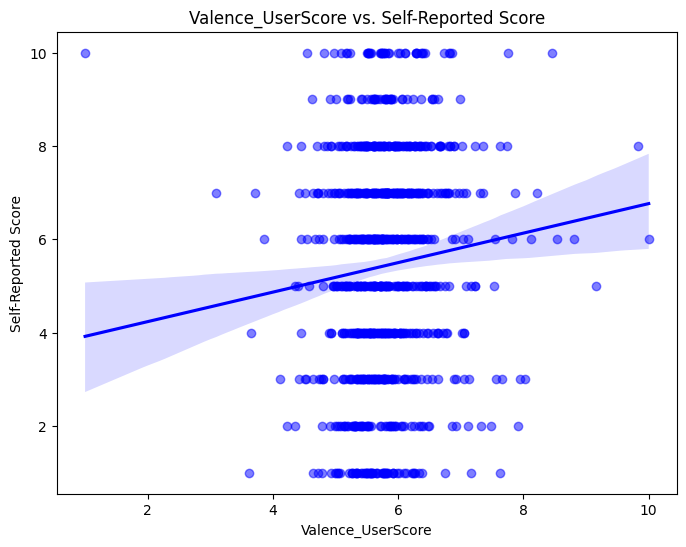

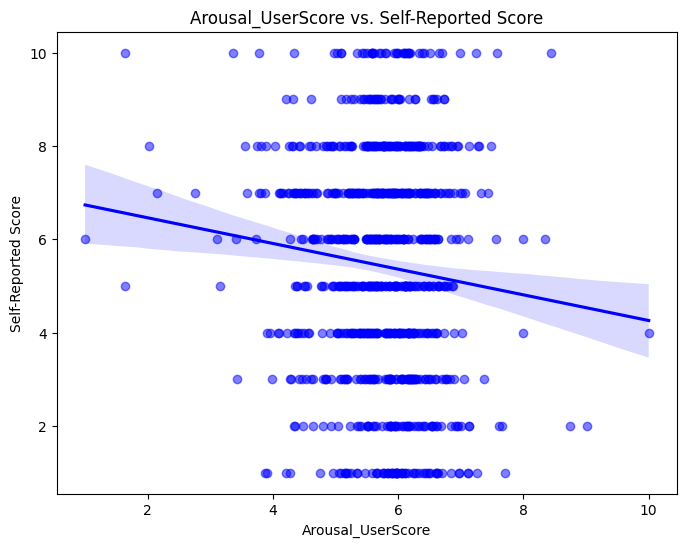

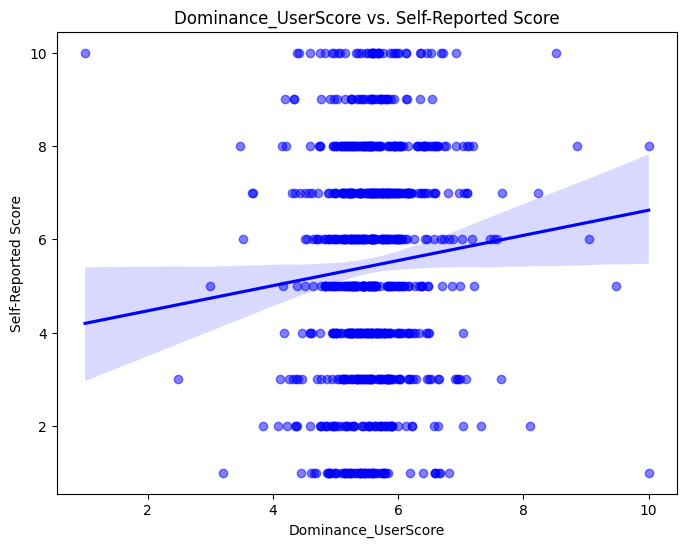

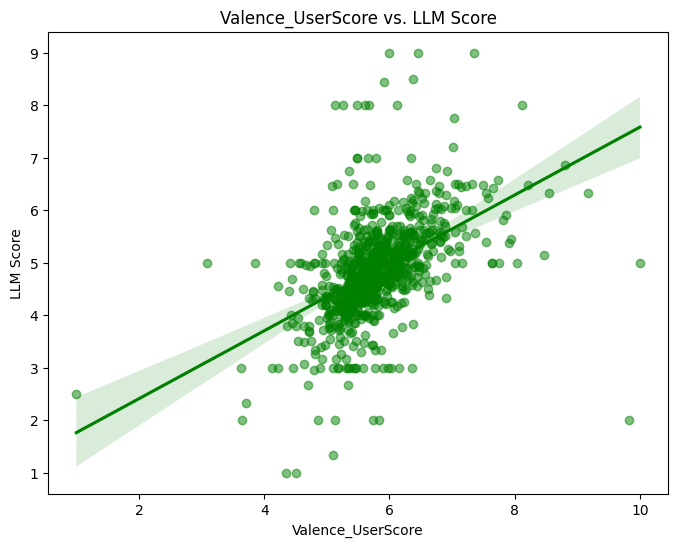

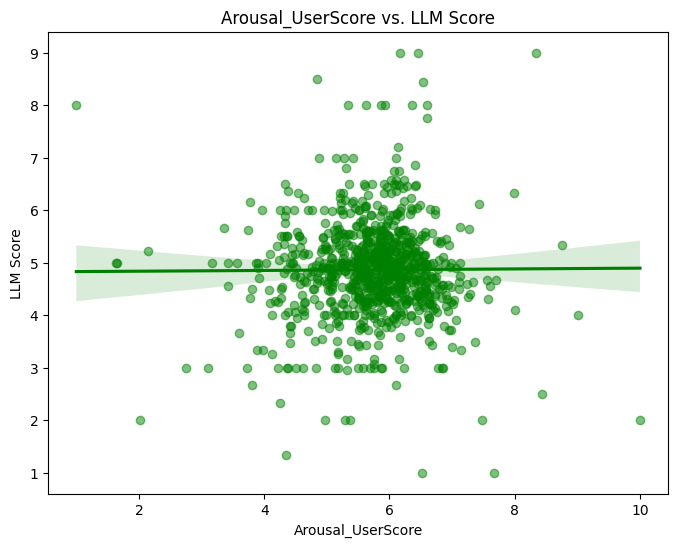

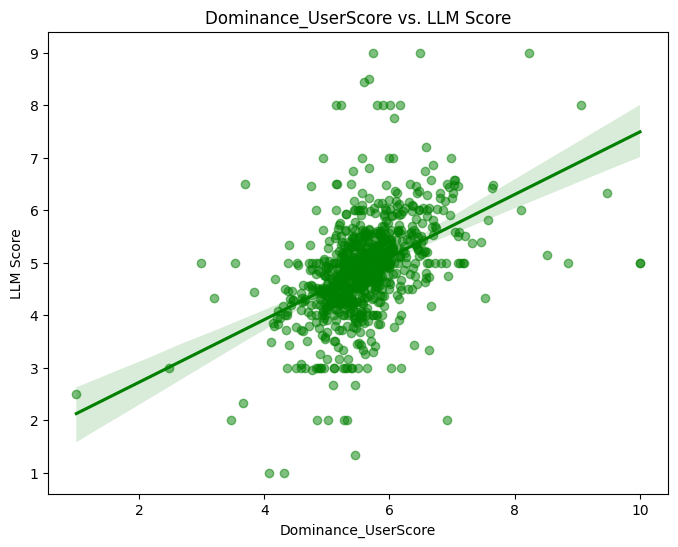

Correlation between LLM Score and Self-Reported Score: 0.1563
P-value: 0.0000


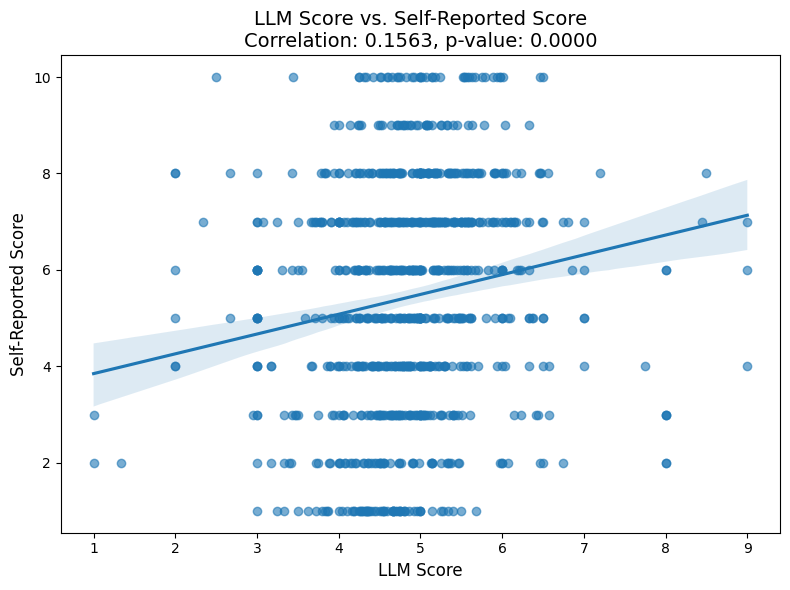

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot for each dimension vs. self-reported score
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=user_scores[dimension], y=user_scores['SelfReportedScore'], scatter_kws={'alpha':0.5}, color='blue')
    plt.title(f"{dimension} vs. Self-Reported Score")
    plt.xlabel(dimension)
    plt.ylabel("Self-Reported Score")
    plt.show()

# Scatterplot for each dimension vs. LLM score
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=user_scores[dimension], y=user_scores['LlmScore'], scatter_kws={'alpha':0.5}, color='green')
    plt.title(f"{dimension} vs. LLM Score")
    plt.xlabel(dimension)
    plt.ylabel("LLM Score")
    plt.show()

user_scores_clean = user_scores[['LlmScore', 'SelfReportedScore']].replace([np.inf, -np.inf], np.nan).dropna()

# Compute correlation and p-value
corr, p_value = pearsonr(user_scores_clean['LlmScore'], user_scores_clean['SelfReportedScore'])

print(f"Correlation between LLM Score and Self-Reported Score: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Plotting
plt.figure(figsize=(8, 6))
sns.regplot(x='LlmScore', y='SelfReportedScore', data=user_scores_clean, scatter_kws={'alpha':0.6})
plt.title(f'LLM Score vs. Self-Reported Score\nCorrelation: {corr:.4f}, p-value: {p_value:.4f}', fontsize=14)
plt.xlabel('LLM Score', fontsize=12)
plt.ylabel('Self-Reported Score', fontsize=12)
plt.tight_layout()
plt.show()


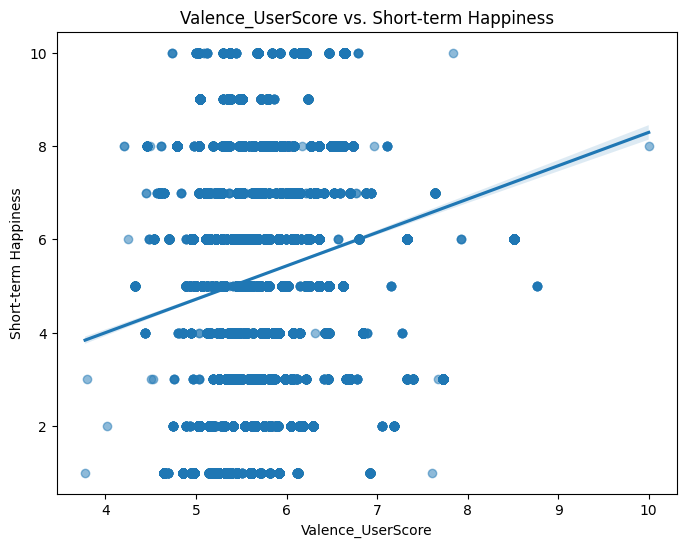

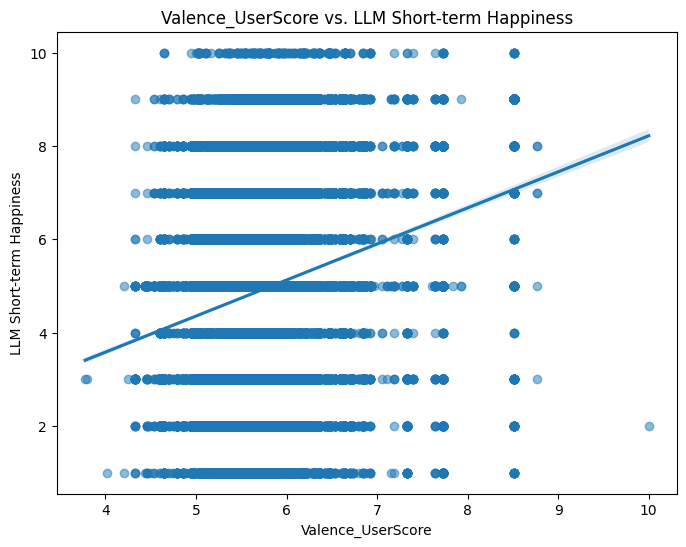

Short-term Happiness - Correlation between Valence_UserScore and Self-Reported Score: 0.1575, p-value: 0.0000
Short-term Happiness - Correlation between Valence_UserScore and LLM Score: 0.2096, p-value: 0.0000


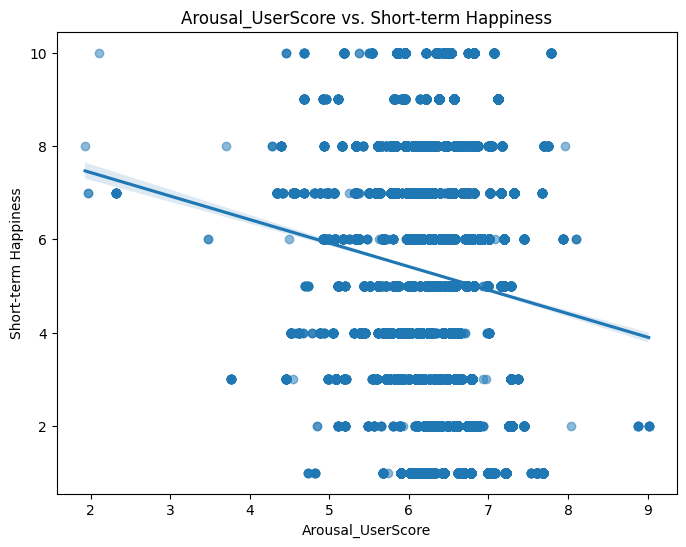

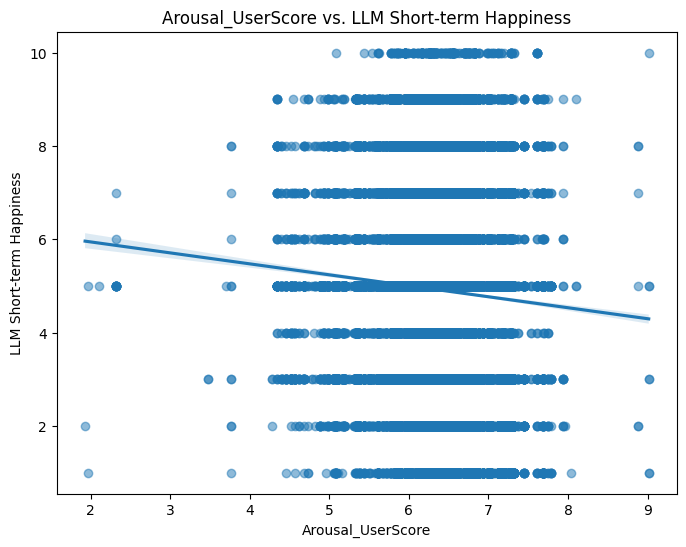

Short-term Happiness - Correlation between Arousal_UserScore and Self-Reported Score: -0.0940, p-value: 0.0000
Short-term Happiness - Correlation between Arousal_UserScore and LLM Score: -0.0540, p-value: 0.0000


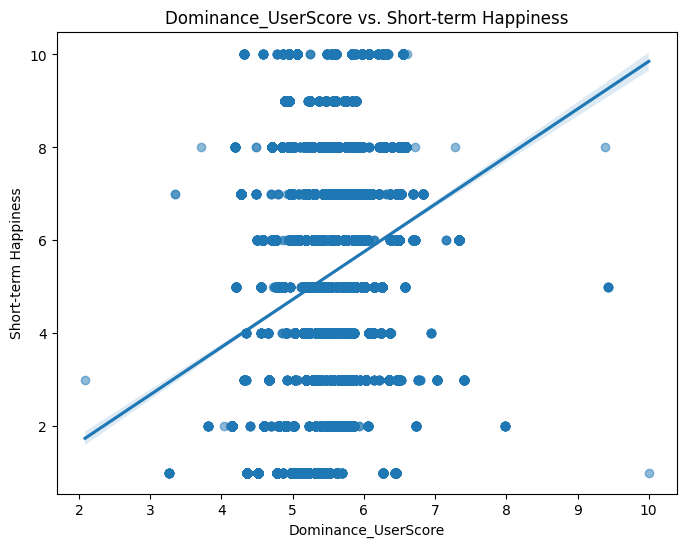

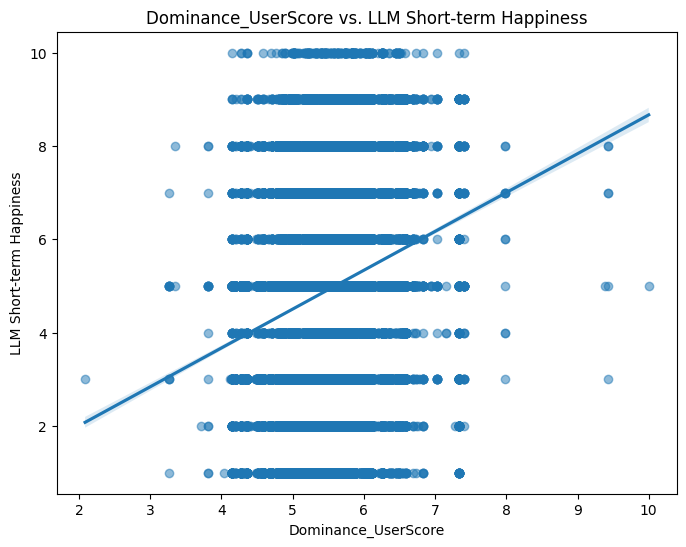

Short-term Happiness - Correlation between Dominance_UserScore and Self-Reported Score: 0.1996, p-value: 0.0000
Short-term Happiness - Correlation between Dominance_UserScore and LLM Score: 0.1998, p-value: 0.0000


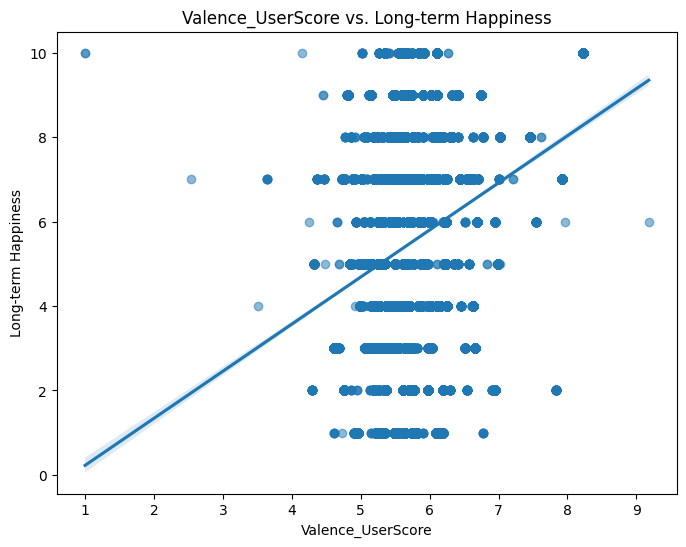

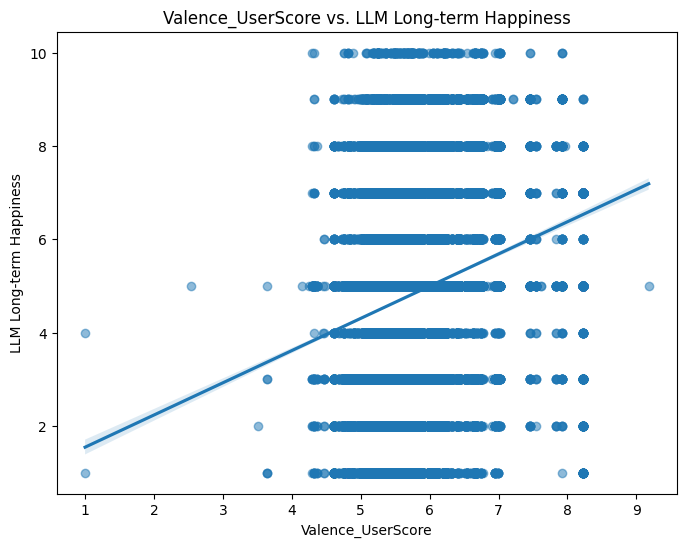

Long-term Happiness - Correlation between Valence_UserScore and Self-Reported Score: 0.2191, p-value: 0.0000
Long-term Happiness - Correlation between Valence_UserScore and LLM Score: 0.1714, p-value: 0.0000


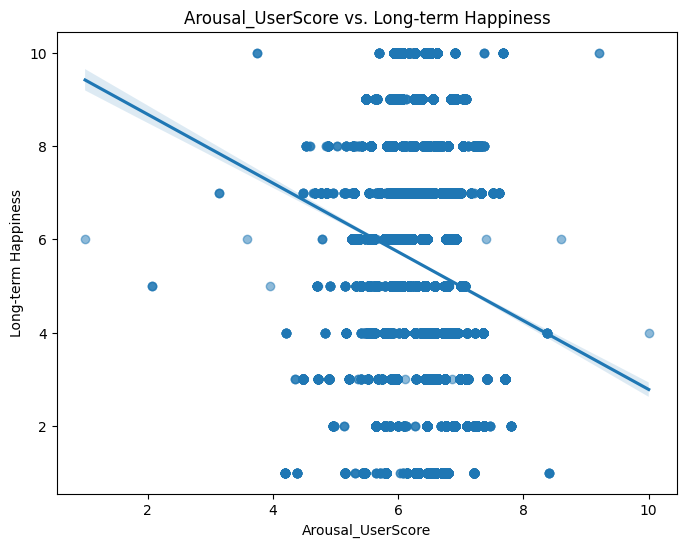

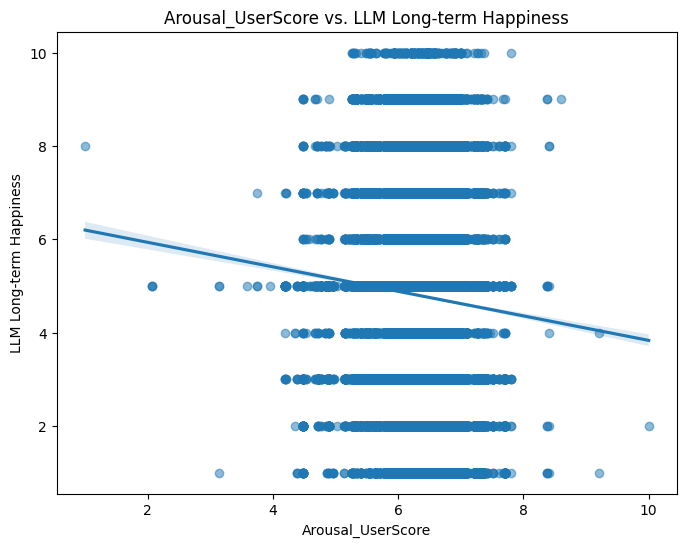

Long-term Happiness - Correlation between Arousal_UserScore and Self-Reported Score: -0.1332, p-value: 0.0000
Long-term Happiness - Correlation between Arousal_UserScore and LLM Score: -0.0600, p-value: 0.0000


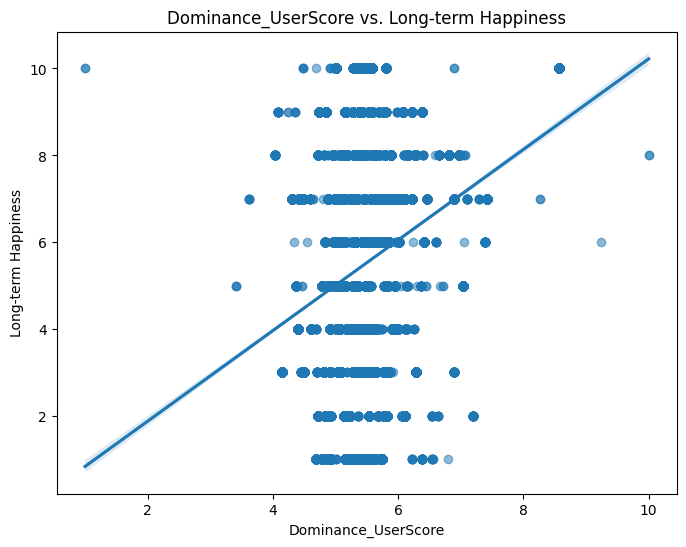

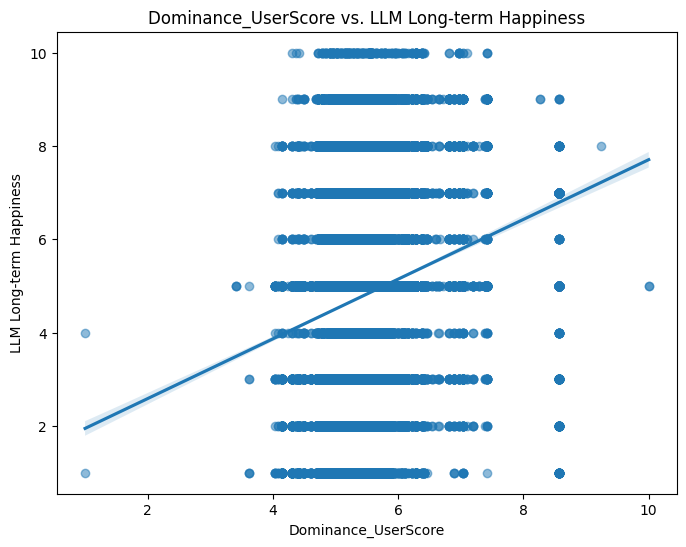

Long-term Happiness - Correlation between Dominance_UserScore and Self-Reported Score: 0.2038, p-value: 0.0000
Long-term Happiness - Correlation between Dominance_UserScore and LLM Score: 0.1582, p-value: 0.0000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

# Load the data
user_scores = pd.read_csv('Updated_RedditSampleLlmScores.csv')

def plot_dimension_vs_scores(subset, dimension, score_type, label):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=subset[dimension], y=subset[score_type], scatter_kws={'alpha':0.5})
    plt.title(f"{dimension} vs. {label}")
    plt.xlabel(dimension)
    plt.ylabel(label)
    plt.show()

def process_data(user_scores, question_id, label):
    # Filter data for the specific question ID
    subset = user_scores[user_scores['QuestionID'] == question_id]

    # Drop rows with NaNs or infs in the relevant columns
    subset = subset.replace([np.inf, -np.inf], np.nan).dropna(subset=['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore', 'Score', 'LlmScore'])

    # Scatterplot for each dimension vs. self-reported and LLM score
    for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
        plot_dimension_vs_scores(subset, dimension, 'Score', label)
        plot_dimension_vs_scores(subset, dimension, 'LlmScore', 'LLM ' + label)

        # Compute correlations
        corr_sr, p_value_sr = pearsonr(subset[dimension], subset['Score'])
        corr_llm, p_value_llm = pearsonr(subset[dimension], subset['LlmScore'])

        print(f"{label} - Correlation between {dimension} and Self-Reported Score: {corr_sr:.4f}, p-value: {p_value_sr:.4f}")
        print(f"{label} - Correlation between {dimension} and LLM Score: {corr_llm:.4f}, p-value: {p_value_llm:.4f}")

# Process and plot for Q1 and Q2
process_data(user_scores, 'Q1', 'Short-term Happiness')
process_data(user_scores, 'Q2', 'Long-term Happiness')

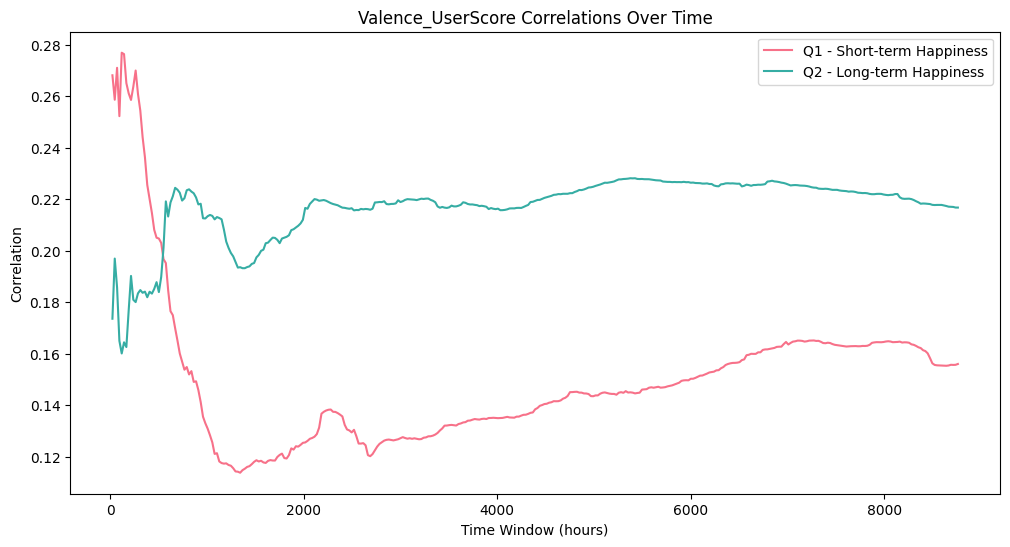

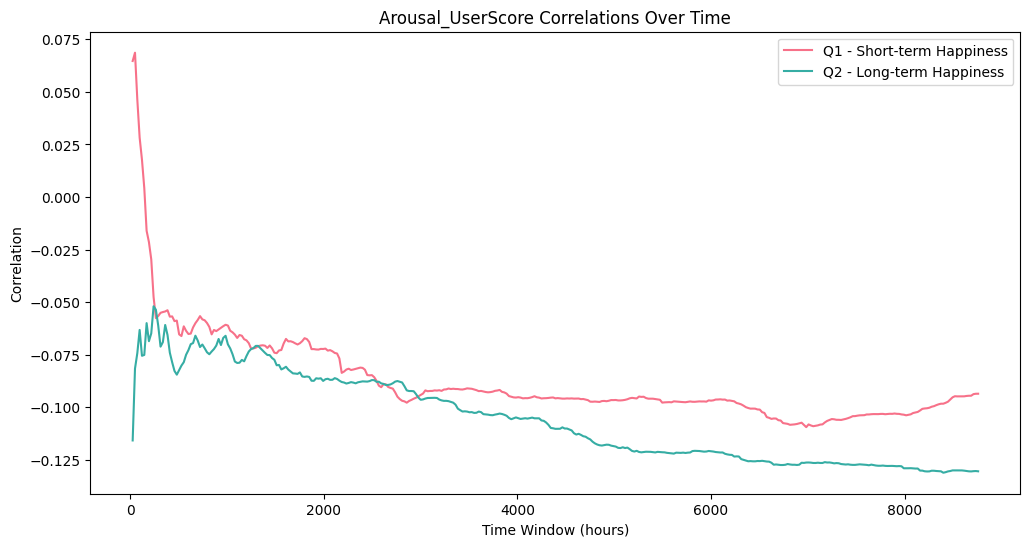

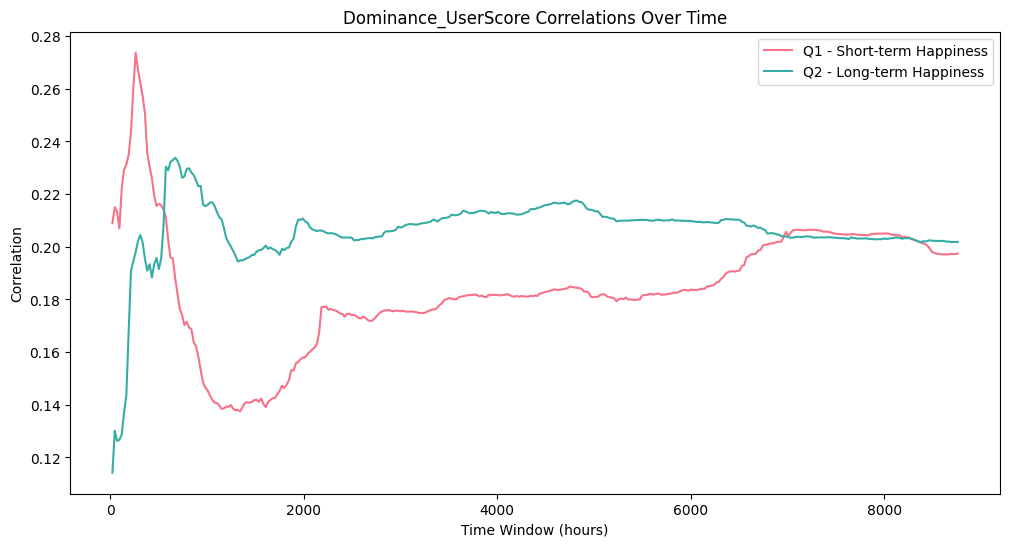

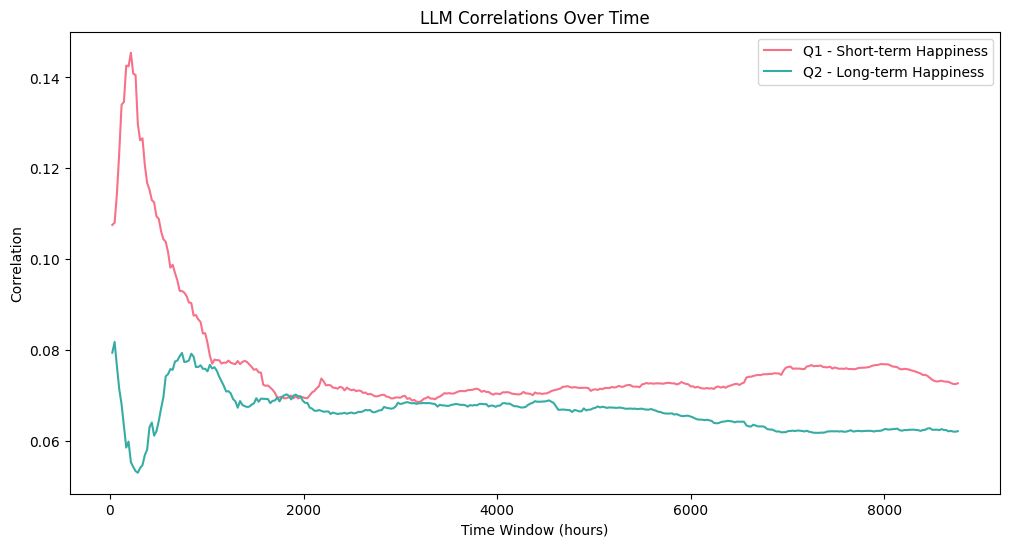

'/mnt/data/correlation_timeseries_results.csv'

In [ ]:
# Let's first create the directory and then save the CSV file.
import os

# Create the directory if it does not exist
output_folder = '/mnt/data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the DataFrame to a CSV file in the created directory
output_file = os.path.join(output_folder, 'correlation_timeseries_results.csv')
correlation_df.to_csv(output_file, index=False)

output_file  # Return the path to the saved CSV file
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import os

# Load the data
user_scores = pd.read_csv('Updated_RedditSampleLlmScores.csv')

# Round TimeDifferenceHours to the nearest integer
user_scores['TimeDifferenceHours'] = user_scores['TimeDifferenceHours'].round().astype(int)

# Define the time windows
time_windows = range(24, user_scores['TimeDifferenceHours'].max() + 24, 24)

# Prepare to store results
correlation_results = []

# Process each question separately for each relevant score column
for question_id, label in [('Q1', 'Short-term Happiness'), ('Q2', 'Long-term Happiness')]:
    question_scores = user_scores[user_scores['QuestionID'] == question_id]

    for window in time_windows:
        subset = question_scores[question_scores['TimeDifferenceHours'] <= window]

        if not subset.empty:
            # Calculate correlations for each sentiment dimension
            for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
                valid_subset_sr = subset.dropna(subset=[dimension, 'Score'])
                if not valid_subset_sr.empty:
                    corr_sr, p_value_sr = pearsonr(valid_subset_sr[dimension], valid_subset_sr['Score'])
                else:
                    corr_sr, p_value_sr = np.nan, np.nan

                correlation_results.append({
                    'TimeWindow': window,
                    'QuestionID': question_id,
                    'Dimension': dimension,
                    'Correlation': corr_sr
                })

            # Calculate correlations for LLM_Score
            valid_subset_llm = subset.dropna(subset=['LlmScore', 'Score'])
            if not valid_subset_llm.empty:
                corr_llm, p_value_llm = pearsonr(valid_subset_llm['LlmScore'], valid_subset_llm['Score'])
            else:
                corr_llm, p_value_llm = np.nan, np.nan

            correlation_results.append({
                'TimeWindow': window,
                'QuestionID': question_id,
                'Dimension': 'LLM',
                'Correlation': corr_llm
            })

# Convert results to DataFrame and save to CSV
correlation_df = pd.DataFrame(correlation_results)
output_folder = '/mnt/data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file = os.path.join(output_folder, 'correlation_timeseries_results.csv')
correlation_df.to_csv(output_file, index=False)

# Plot the results: each dimension and LLM get their own graph
palette = sns.color_palette("husl", 2)  # Different colors for Q1 and Q2
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore', 'LLM']:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=correlation_df[(correlation_df['Dimension'] == dimension) & (correlation_df['QuestionID'] == 'Q1')],
                 x='TimeWindow', y='Correlation', label='Q1 - Short-term Happiness', color=palette[0])
    sns.lineplot(data=correlation_df[(correlation_df['Dimension'] == dimension) & (correlation_df['QuestionID'] == 'Q2')],
                 x='TimeWindow', y='Correlation', label='Q2 - Long-term Happiness', color=palette[1])
    plt.title(f'{dimension} Correlations Over Time')
    plt.xlabel('Time Window (hours)')
    plt.ylabel('Correlation')
    plt.legend()
    plt.show()

# Provide the path to the saved CSV file
output_file

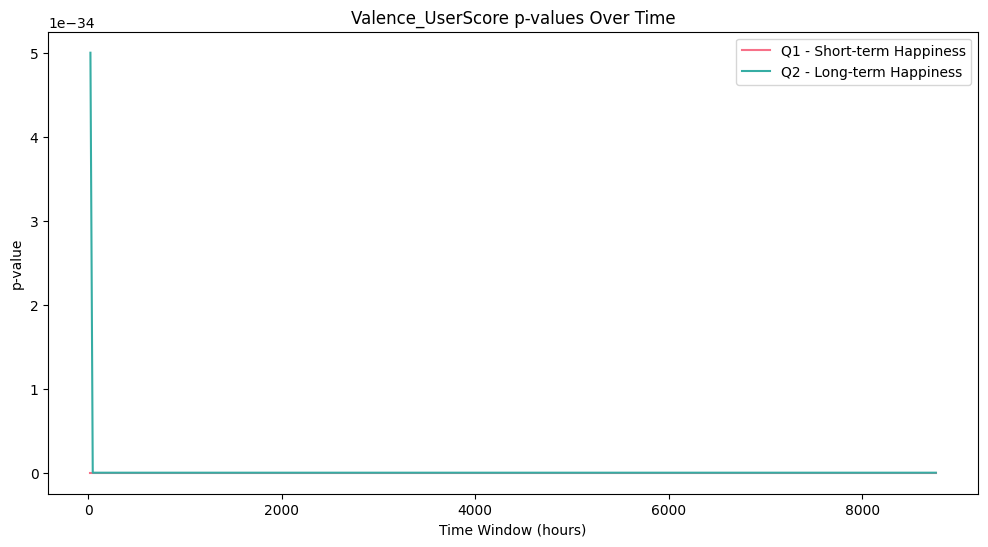

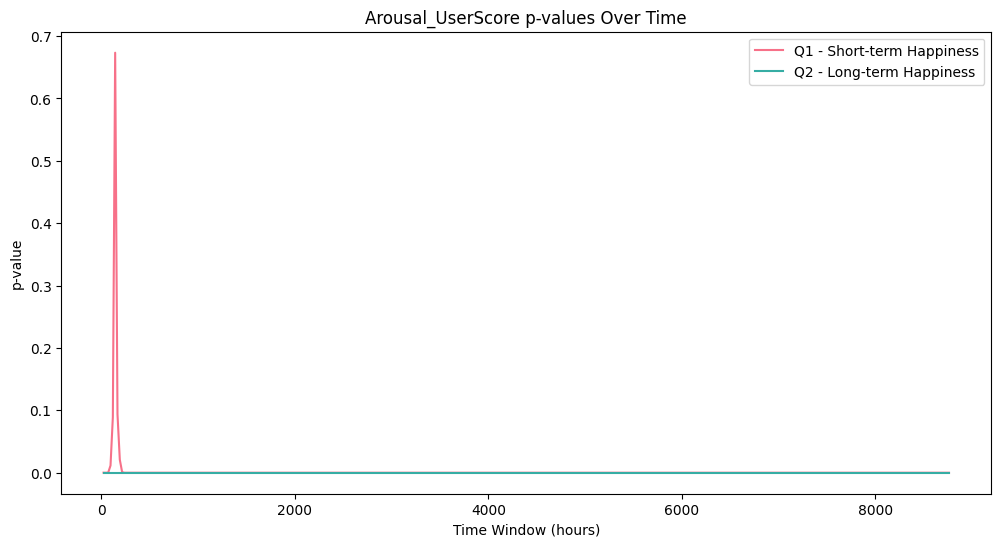

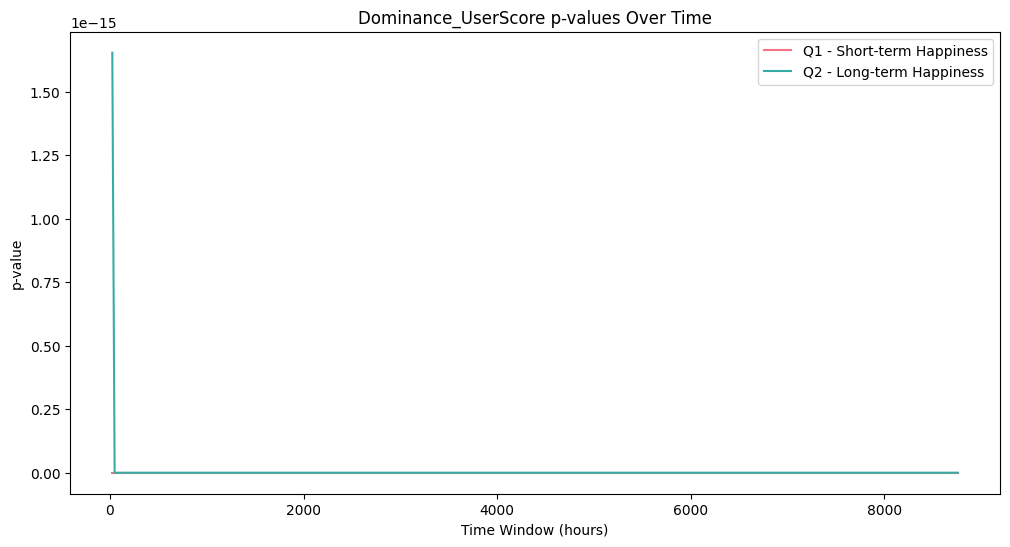

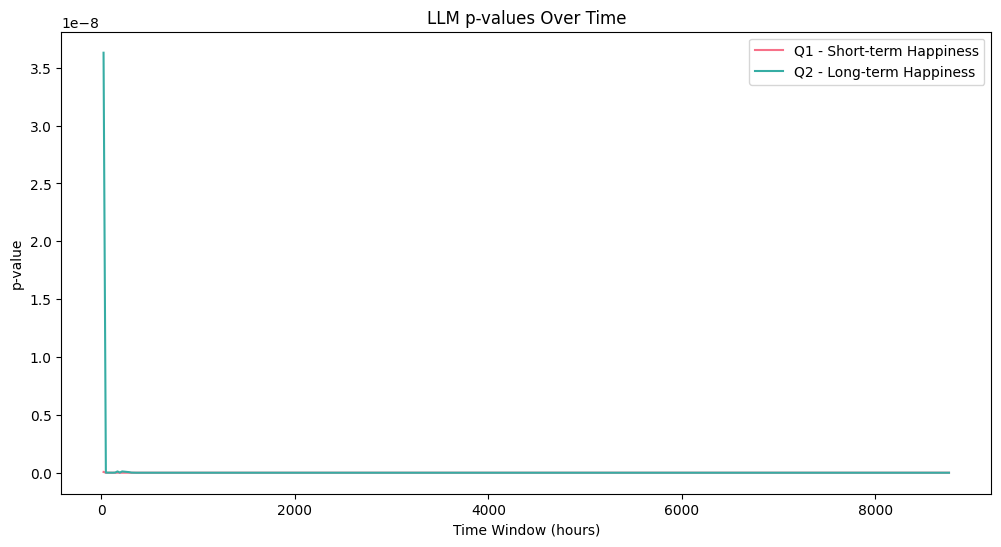

'/mnt/data/p_value_timeseries_results.csv'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import os

# Load the data
user_scores = pd.read_csv('Updated_RedditSampleLlmScores.csv')

# Round TimeDifferenceHours to the nearest integer
user_scores['TimeDifferenceHours'] = user_scores['TimeDifferenceHours'].round().astype(int)

# Define the time windows
time_windows = range(24, user_scores['TimeDifferenceHours'].max() + 24, 24)

# Prepare to store results
p_value_results = []

# Process each question separately for each relevant score column
for question_id, label in [('Q1', 'Short-term Happiness'), ('Q2', 'Long-term Happiness')]:
    question_scores = user_scores[user_scores['QuestionID'] == question_id]

    for window in time_windows:
        subset = question_scores[question_scores['TimeDifferenceHours'] <= window]

        if not subset.empty:
            # Calculate p-values for each sentiment dimension
            for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore']:
                valid_subset_sr = subset.dropna(subset=[dimension, 'Score'])
                if not valid_subset_sr.empty:
                    _, p_value_sr = pearsonr(valid_subset_sr[dimension], valid_subset_sr['Score'])
                else:
                    p_value_sr = np.nan

                p_value_results.append({
                    'TimeWindow': window,
                    'QuestionID': question_id,
                    'Dimension': dimension,
                    'p_value': p_value_sr
                })

            # Calculate p-value for LLM_Score
            valid_subset_llm = subset.dropna(subset=['LlmScore', 'Score'])
            if not valid_subset_llm.empty:
                _, p_value_llm = pearsonr(valid_subset_llm['LlmScore'], valid_subset_llm['Score'])
            else:
                p_value_llm = np.nan

            p_value_results.append({
                'TimeWindow': window,
                'QuestionID': question_id,
                'Dimension': 'LLM',
                'p_value': p_value_llm
            })

# Convert results to DataFrame and save to CSV
p_value_df = pd.DataFrame(p_value_results)
output_folder = '/mnt/data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file = os.path.join(output_folder, 'p_value_timeseries_results.csv')
p_value_df.to_csv(output_file, index=False)

# Plot the results: each dimension and LLM get their own graph for p-values
palette = sns.color_palette("husl", 2)  # Different colors for Q1 and Q2
for dimension in ['Valence_UserScore', 'Arousal_UserScore', 'Dominance_UserScore', 'LLM']:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=p_value_df[(p_value_df['Dimension'] == dimension) & (p_value_df['QuestionID'] == 'Q1')],
                 x='TimeWindow', y='p_value', label='Q1 - Short-term Happiness', color=palette[0])
    sns.lineplot(data=p_value_df[(p_value_df['Dimension'] == dimension) & (p_value_df['QuestionID'] == 'Q2')],
                 x='TimeWindow', y='p_value', label='Q2 - Long-term Happiness', color=palette[1])
    plt.title(f'{dimension} p-values Over Time')
    plt.xlabel('Time Window (hours)')
    plt.ylabel('p-value')
    plt.legend()
    plt.show()

# Provide the path to the saved CSV file
output_file